Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
# install necessary dependencies
# !pip uninstall -r requirements.txt

In [2]:
!pip show jax

Name: jax
Version: 0.4.35
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /home/dung10/code/trajax/.venv/lib/python3.10/site-packages
Requires: jaxlib, ml-dtypes, numpy, opt-einsum, scipy
Required-by: brax, chex, flax, jaxopt, mujoco-mjx, optax, orbax-checkpoint, trajax


In [3]:
# from jax.config import config
# config.update('jax_enable_x64', True)

import jax.numpy as jnp
import jax

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from importlib import reload

In [5]:
from trajax import integrators
from trajax.experimental.sqp import shootsqp, util

In [ ]:
reload(shootsqp)
reload(util)

<module 'trajax.experimental.sqp.util' from '/home/dung10/code/trajax/.venv/lib/python3.10/site-packages/trajax/experimental/sqp/util.py'>

# Define Dynamics via Lagrangian approach

In [ ]:
from jax import grad, jvp

n = 8
m = 2

Mass=0.486
mass = 0.2*Mass
grav = 9.81
l = 0.25
L = 2*l
J = 0.00383
fric = 0.01
u_hover = 0.5*(Mass+mass)*grav*jnp.ones((m,))

# State: q = (p_x, p_y, theta, phi, velocities)
# where theta: rotation angle of quad
# phi: rotation angle of pendulum, w.r.t. vertical (NOTE: not a relative angle)

def get_mass_matrix(q):
  phi = q[-1]
  M_q = jnp.array([[Mass+mass, 0., 0., mass*L*jnp.cos(phi)],
                  [0., Mass+mass, 0., mass*L*jnp.sin(phi)],
                  [0., 0., J, 0.],
                  [mass*L*jnp.cos(phi), mass*L*jnp.sin(phi), 0., mass*L*L]])
  return M_q

def get_mass_inv(q):
  phi = q[-1]
  a = Mass + mass
  b = mass*L*jnp.cos(phi)
  c = mass*L*jnp.sin(phi)
  d = mass*L*L
  den = (mass*L)**2. - a*d
  M_inv = jnp.array([[(c*c-a*d)/(a*den), -(b*c)/(a*den), 0., (b/den)],
                    [-(b*c)/(a*den), (b*b-a*d)/(a*den), 0., (c/den)],
                    [0., 0., (1./J), 0.],
                    [(b/den), (c/den), 0., -(a/den)]])
  return M_inv

kinetic = lambda q, q_dot: 0.5 * jnp.vdot(q_dot, get_mass_matrix(q) @ q_dot)
potential = lambda q: Mass*grav*q[1] + mass*grav*(q[1] - L*jnp.cos(q[-1]))
lag = lambda q, q_dot: kinetic(q, q_dot) - potential(q)
dL_dq = grad(lag, 0)

@jax.jit
def ode(x, u, t):
  del t
  q, q_dot = jnp.split(x, [4])
  # (M_q * q_ddot + M_dot * q_dot) - (dL_dq) = F_q
  M_q, M_dot = jvp(get_mass_matrix, (q,), (q_dot,))
  M_inv = get_mass_inv(q)
  torque_fric_pole = -fric * (q_dot[-1] - q_dot[-2])
  F_q = jnp.array([-jnp.sum(u)*jnp.sin(q[2]),
                   jnp.sum(u)*jnp.cos(q[2]),
                  (u[0]-u[1])*l - torque_fric_pole,
                  torque_fric_pole])
  q_ddot = M_inv @ (F_q + dL_dq(q, q_dot) - (M_dot @ q_dot))
  return jnp.concatenate((q_dot, q_ddot))

dt = 0.025
dynamics = integrators.euler(ode, dt)

In [ ]:
from jax import random
key = random.PRNGKey(1234)

In [ ]:
# Confirm mass matrix and inverse computation
q = random.uniform(key, shape=(4,))
np.allclose(get_mass_matrix(q) @ get_mass_inv(q), np.eye(4))

False

# Define Quad Geometry

In [ ]:
# Define Geometry

quad = (jnp.array([[-l, 0.],
                   [l, 0.]]),
        jnp.array([[-l, 0.],
                  [-l, 0.3*l]]),
        jnp.array([[l, 0.],
                  [l, 0.3*l]]),
        jnp.array([[-1.3*l, 0.3*l],
                  [-0.7*l, 0.3*l]]),
        jnp.array([[0.7*l, 0.3*l],
                  [1.3*l, 0.3*l]]))

def render_quad(ax, x, y, theta, phi, col=None, show_ell=0.05):

  pos = jnp.array([x, y])
  R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                [jnp.sin(theta), jnp.cos(theta)]])

  # Update quad endpoints
  quad_comps = tuple(v @ R.T + pos for v in quad)

  for comp in quad_comps:
    ax.plot(comp[:,0], comp[:,1],
            color=col if col is not None else 'k', linewidth=2)

  # Circumscribing sphere for quad
  pos_c = pos + R @ jnp.array([0., 0.15*l])
  ell = plt.Circle(pos_c, l, alpha=show_ell, color='k')
  ax.add_patch(ell)

  # Pole
  pole_new = jnp.array([[x, y],
                       [x + L*jnp.sin(phi), y - L*jnp.cos(phi)]])
  ax.plot(pole_new[:,0], pole_new[:,1], 'o-',
          color=col if col is not None else 'b')

# Define Problem

## Setup Obstacle environment

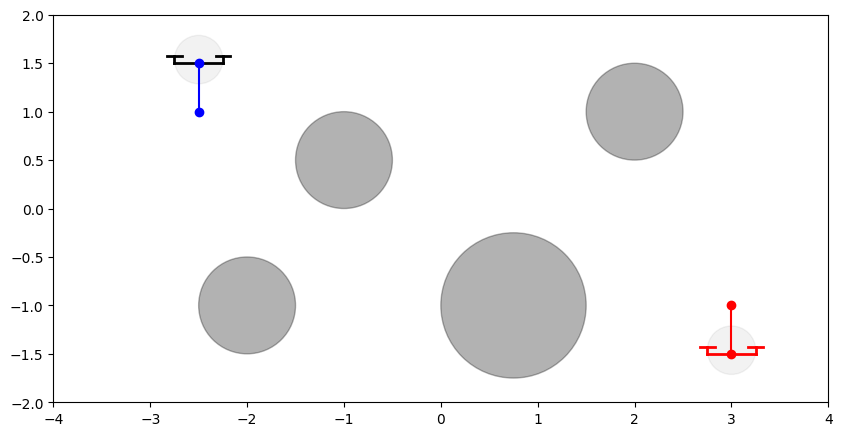

In [ ]:
#@title {vertical-output: true}

pos_0 = jnp.array([-2.5, 1.5, 0., 0])
# pos_0 = jnp.array([-3., 0.5, 0., 0])
pos_g = jnp.array([3., -1.5, 0., jnp.pi])

obs = [(jnp.array([-1., 0.5]), 0.5),
       (jnp.array([0.75, -1.]), 0.75),
       (jnp.array([-2., -1.]), 0.5),
       (jnp.array([2., 1.]), 0.5)]

world_range = (jnp.array([-4., -2.]), jnp.array([4., 2.]))

def render_scene():
  fig = plt.figure(figsize=(10, 15))
  ax = fig.add_subplot(111)
  plt.grid(False)
  for ob in obs:
    ax.add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.3))

  ax.set_xlim([world_range[0][0], world_range[1][0]])
  ax.set_ylim([world_range[0][1], world_range[1][1]])
  ax.set_aspect('equal', adjustable='box')

  return fig, ax

_, ax = render_scene()
render_quad(ax, pos_0[0], pos_0[1], pos_0[2], pos_0[3])
render_quad(ax, pos_g[0], pos_g[1], pos_g[2], pos_g[3], col='r')

In [ ]:
# Extract obstacle avoidance constraint
def get_closest_point(endp, p_o):
  """Get closest point between point and straight-line between endpoints."""
  x, y = endp
  t_ = jnp.vdot(p_o - x, y - x)/jnp.vdot(y - x, y - x)
  t_min = jnp.minimum(1., jnp.maximum(0., t_))
  p_min = x + t_min * (y - x)
  return p_min

def obs_constraint(q):
  pos = q[:2]
  theta = q[2]
  phi = q[-1]

  R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                [jnp.sin(theta), jnp.cos(theta)]])
  pos_c = pos + R @ jnp.array([0., 0.15*l])
  pole = (pos,
          pos + jnp.array([L*jnp.sin(phi), -L*jnp.cos(phi)]))

  def avoid_obs(pos_c, pole, ob):
    delta_body = pos_c - ob[0]
    body_dist_sq = jnp.vdot(delta_body, delta_body) - (ob[1] + l)**2
    pole_p = get_closest_point(pole, ob[0])
    delta_pole = pole_p - ob[0]
    pole_dist_sq = jnp.vdot(delta_pole, delta_pole) - (ob[1]**2)
    return jnp.array([body_dist_sq, pole_dist_sq])

  return jnp.concatenate([avoid_obs(pos_c, pole, ob) for ob in obs])


## Setup Dynamics, cost, constraints

In [ ]:
# Constants
n, m, T = (8, 2, 160)

# Do angle wrapping on theta and phi
s1_ind = (2, 3)
state_wrap = util.get_s1_wrapper(s1_ind)

# Goal and terminal cost
goal = jnp.concatenate((pos_g, jnp.zeros((4,))))

@jax.jit
def cost(x, u, t, weights=(1., 1., 1.), Q_T=(1., 1., 1., 1., 1., 1., 1., 1.)):

  delta = state_wrap(x - goal)
  pos_cost = jnp.vdot(delta[:3], delta[:3]) + (1. + jnp.cos(x[3]))
  ctrl_cost = jnp.vdot(u - u_hover, u - u_hover)

  stage_cost = weights[0] * pos_cost + weights[1] * ctrl_cost
  term_cost = weights[2] * jnp.vdot(delta, jnp.array(Q_T) * delta)

  return jnp.where(t==T, 0.5*term_cost, 0.5*stage_cost)

@jax.jit
def state_constraint(x, t, theta_lim=jnp.pi/2.):
  # Require c_x(x[t], t) >= 0
  # theta \in [-theta_lim, theta_lim]
  theta_cons = jnp.array((x[2] + theta_lim,
                         theta_lim - x[2]))

  # obs cons
  avoid_cons = obs_constraint(x[:4])

  # world_cons
  world_cons = jnp.concatenate((x[:2] - world_range[0],
                               world_range[1] - x[:2]))

  return jnp.concatenate((theta_cons, world_cons, avoid_cons))

control_bounds = (0.1*Mass*grav*jnp.ones((m,)),
                  3.0*Mass*grav*jnp.ones((m,)))

# Define Solver

In [ ]:
# Define Solver

# OPEN:
# QP_ECOS: FAIL
# QP_ALILQR: LATE STALL

# STABLE:
# QP_ECOS: EARLY STALL
# QP_ALILQR: EARLY STALL

# Sensitivity methods:
# qp_solver: QP_ECOS:
# SENS: {1e-3, 0.1}; SOLVED
# APPROX_SENS: {1e-3}; SOLVED

# qp_solver: QP_ALILQR:
# SENS: {1e-3, 0.1}, {1e-4, [0.1, 1.0]}; SOLVED
# APPROX_SENS {1e-4}; SOLVED

solver_options = dict(method=shootsqp.SQP_METHOD.APPROX_SENS,
                      qp_solver=shootsqp.QP_SOLVER.QP_ALILQR,
                      hess="full", verbose=True,
                      max_iter=100, ls_eta=0.49, ls_beta=0.8,
                      primal_tol=1e-3, dual_tol=1e-2, stall_check="abs",
                      ddp_options={'ddp_gamma': 1e-4, 'ddp_gamma_ratio': 1.0},
                      debug=False)

solver = shootsqp.ShootSQP(n, m, T, dynamics, cost, control_bounds,
                           state_constraint, s1_ind=s1_ind, **solver_options)

# Solve

## Set initial conditions and guess

In [ ]:
# Solve
x0 = jnp.concatenate((pos_0, jnp.zeros((4,))))
U0 = jnp.tile(u_hover, (T, 1))

weights = (0.01, 0.05, 5.)
Q_T = (10., 10., 1., 1., 1., 1., 1., 1.)
theta_lim = 3.*jnp.pi/4.

cost_params = (weights, Q_T)
cons_params = (theta_lim,)
prob_params = (cost_params, cons_params)

## Solve

In [ ]:
# Run for one iteration to jit first
solver.opt.max_iter = 1
_ = solver.solve(x0, U0, params=prob_params)

{'cslack': (Array(0., dtype=float32), Array(0., dtype=float32)), 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)), 'obj': Array(1038.9232, dtype=float32), 'primal': (Array(2.38383, dtype=float32), Array(0.5, dtype=float32)), 'stat': Array(42043.285, dtype=float32)}
|dU - dU_ddp|: 0.4451621174812317, |ddp_grad|: 565.783935546875
SOLVE: it: 1, obj: 828.7919921875, |dU|: 4.879349708557129, step-length: 1.0, rho: 0.0
Status: MAXITER, obj: 828.7919921875


In [ ]:
# Run to completion
solver.opt.max_iter = 100
soln = solver.solve(x0, U0, params=prob_params)

{'cslack': (Array(0., dtype=float32), Array(0., dtype=float32)), 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)), 'obj': Array(1038.9232, dtype=float32), 'primal': (Array(2.38383, dtype=float32), Array(0.5, dtype=float32)), 'stat': Array(42043.285, dtype=float32)}
|dU - dU_ddp|: 0.4451621174812317, |ddp_grad|: 565.783935546875
SOLVE: it: 1, obj: 828.7919921875, |dU|: 4.879349708557129, step-length: 1.0, rho: 0.0
{'cslack': (Array(0., dtype=float32), Array(45.357265, dtype=float32)), 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)), 'obj': Array(828.792, dtype=float32), 'primal': (Array(-1.1920929e-07, dtype=float32), Array(0.4975822, dtype=float32)), 'stat': Array(14067.189, dtype=float32)}
|dU - dU_ddp|: 0.8657530546188354, |ddp_grad|: 16966.67578125
SOLVE: it: 2, obj: 686.5963745117188, |dU|: 4.890625, step-length: 0.7192931771278381, rho: 0.0
{'cslack': (Array(0., dtype=float32), Array(26.763859, dtype=float32)), 'dual': (Array(0., dtype=float32), Array(0., 

In [ ]:
print(soln.iterations, soln.objective)
soln.kkt_residuals

4 17469.775


{'cslack': (Array(8.789599, dtype=float32), Array(18554.83, dtype=float32)),
 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)),
 'obj': Array(17469.775, dtype=float32),
 'primal': (Array(0., dtype=float32), Array(-14.190548, dtype=float32)),
 'stat': Array(195252.23, dtype=float32)}

Text(0, 0.5, 'vel')

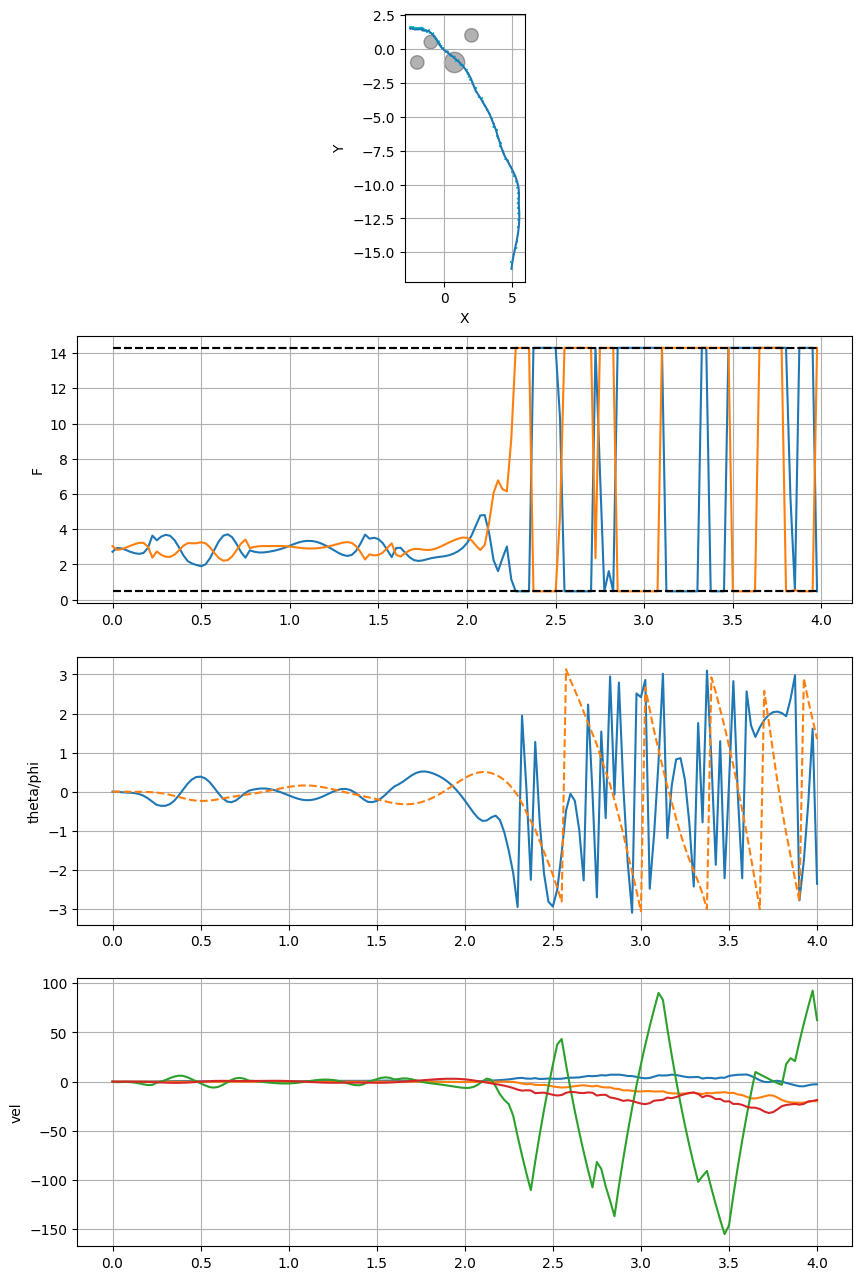

In [ ]:
#@title {vertical-output: true}
%matplotlib inline

U, X = soln.primals

fig, axs = plt.subplots(4, figsize=(10, 16), sharex=False)

# Plot trajectory
axs[0].plot(X[:, 0], X[:, 1])
# Obstacles
for ob in obs:
  axs[0].add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.3))
# Orientations
for t in range(T+1):
  axs[0].arrow(
      X[t, 0], X[t, 1],
      -0.1 * jnp.sin(X[t, 2]), 0.1 * jnp.cos(X[t, 2]),
      width=0.01, color='c')
axs[0].grid(True)
axs[0].set_aspect('equal')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[1].plot(jnp.arange(0, T)*dt, U)
axs[1].plot(jnp.arange(0, T)*dt, control_bounds[0][0]*jnp.ones_like(U), 'k--')
axs[1].plot(jnp.arange(0, T)*dt, control_bounds[1][0]*jnp.ones_like(U), 'k--')
axs[1].grid(True)
axs[1].set_ylabel('F')

axs[2].plot(jnp.arange(0, T+1)*dt, X[:, 2])
axs[2].plot(jnp.arange(0, T+1)*dt, X[:, 3], '--')
axs[2].grid(True)
axs[2].set_ylabel('theta/phi')

axs[3].plot(jnp.arange(0, T+1)*dt, X[:, 4:])
axs[3].grid(True)
axs[3].set_ylabel('vel')


# Plot timelapse

In [ ]:
# Timelapse

def gen_timelapse(ax, X, step0, stepr):
  """Gen timelapse.

  step0: initial step size
  stepr: step-size increase/decrease ratio."""

  # Obstacles
  for ob in obs:
    ax.add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.5))

  # Traj trace
  X_pole = jax.vmap(
      lambda x, y, phi: jnp.array([x + L*jnp.sin(phi), y - L*jnp.cos(phi)]))(
          X[:, 0], X[:, 1], X[:, 3])

  ax.plot(X[:, 0], X[:, 1], 'k--', linewidth=2)
  ax.plot(X_pole[:, 0], X_pole[:, 1], 'b--', linewidth=1)
  ax.set_xlim([world_range[0][0], world_range[1][0]])
  ax.set_ylim([world_range[0][1], world_range[1][1]])
  ax.set_aspect('equal')

  tt = 0
  it = 0
  # print(step0)
  while tt < X.shape[0]:
    col = None
    if tt == 0:
      col = 'g'
    render_quad(ax, X[tt, 0], X[tt, 1], X[tt, 2], X[tt, 3], col, 0.03)
    tt += int(step0 * (stepr ** it))
    it += 1

  # print(step0 * (stepr ** (it-1)))

  render_quad(ax, X[-1, 0], X[-1, 1], X[-1, 2], X[-1, 3], 'r', 0.03)

  # Start
  ax.add_patch(plt.Circle([X[0, 0], X[0, 1]], 0.1, color='g', alpha=0.3))
  # End
  ax.add_patch(plt.Circle([pos_g[0], pos_g[1]], 0.1, color='r', alpha=0.3))


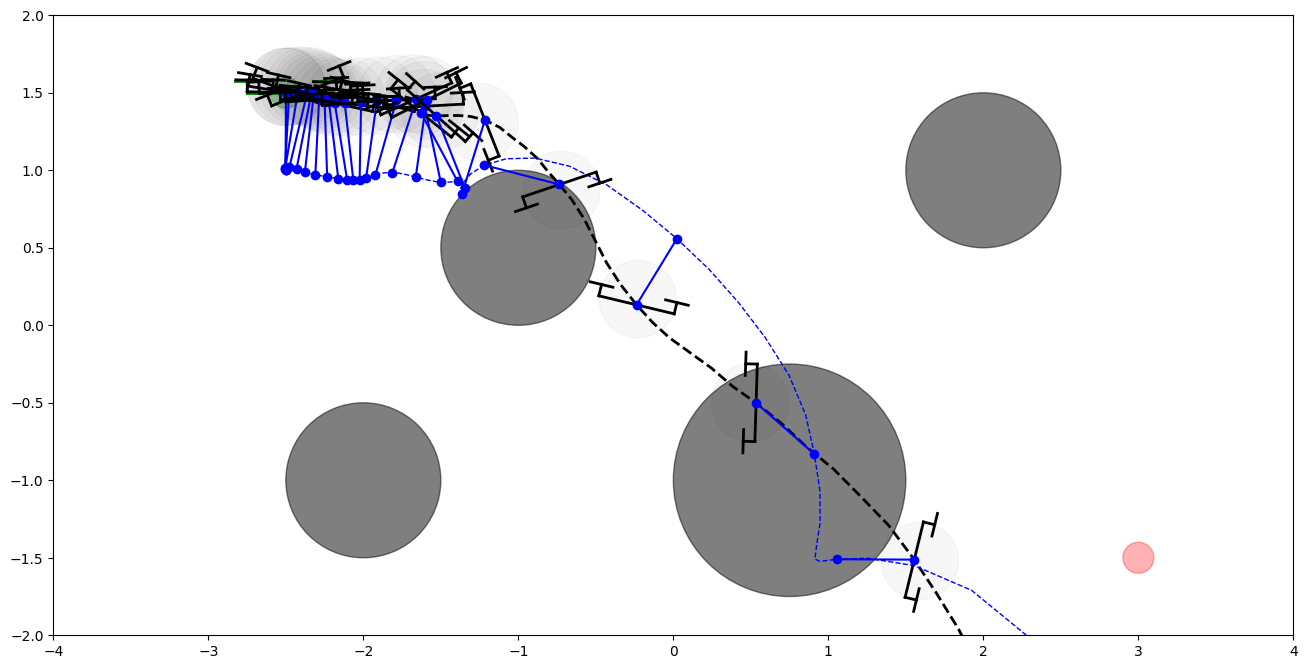

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
plt.grid(False)

gen_timelapse(ax, X, int(0.1/dt), 1.02)


# Generate animation

In [ ]:
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def gen_movie(fig, ax, X):
  """Generate movie."""

  def render(tt):
    ax.clear()
    # Quad
    render_quad(ax, X[tt, 0], X[tt, 1], X[tt, 2], X[tt, 3])
    # Obstacles
    for ob in obs:
      ax.add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.3))
    # Traj trace
    tt_s = int(max(tt - round(0.5/dt), 0))
    ax.plot(X[tt_s:tt, 0], X[tt_s:tt, 1], 'r-', linewidth=2)
    ax.set_xlim([world_range[0][0], world_range[1][0]])
    ax.set_ylim([world_range[0][1], world_range[1][1]])
    ax.set_aspect('equal', adjustable='box')
    return [ax]

  anim = animation.FuncAnimation(
      fig,
      lambda tt: render(tt),
      frames=range(0, X.shape[0]),
      interval=1000 * dt,
      repeat_delay=3000)
  plt.close(fig)

  return anim

In [ ]:
#@title {vertical-output: true}

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(True)
plt.axis('off')
anim = gen_movie(fig, ax, X).to_html5_video()
HTML(anim)

# Plot solver progress

In [ ]:
import seaborn as sns
colors = sns.color_palette("tab10")
color = colors[1]

/home/dung10/code/trajax/.venv/lib/python3.10/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [ ]:
history = soln.history
history.keys()

dict_keys(['steplength', 'obj', 'min_viol', 'ddp_err', 'ddp_err_grad'])

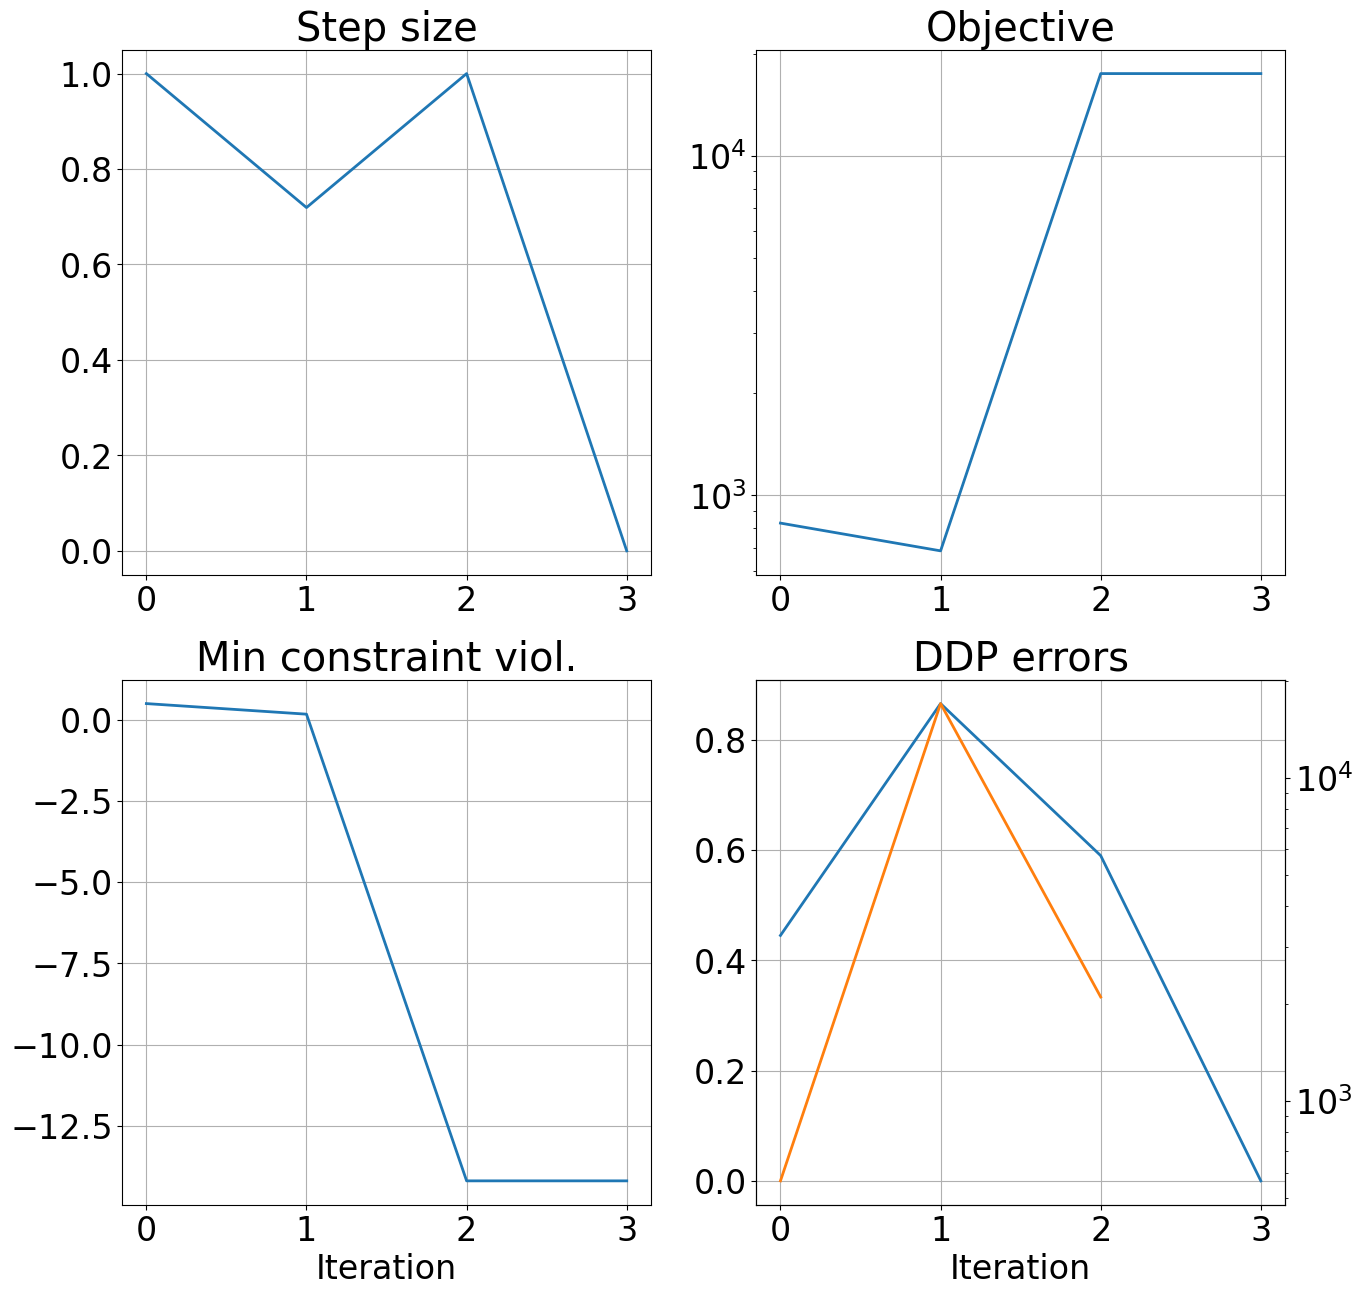

In [ ]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 24})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].plot(history['steplength'], color=colors[0], linewidth=2)
axs[0][0].set_title('Step size')
axs[0][0].grid(True)

axs[0][1].plot(history['obj'], color=colors[0], linewidth=2)
axs[0][1].set_title('Objective')
axs[0][1].set_yscale('log')
axs[0][1].grid(True)

axs[1][0].plot(history['min_viol'], color=colors[0], linewidth=2)
axs[1][0].set_title('Min constraint viol.')
axs[1][0].set_xlabel('Iteration')
axs[1][0].grid(True)

if 'ddp_err' in history:
  axs[1][1].plot(history['ddp_err'], color=colors[0], linewidth=2)
  axs2 = axs[1][1].twinx()
  axs2.plot(history['ddp_err_grad'], color=colors[1], linewidth=2)
  axs2.set_yscale("log")
  axs[1][1].set_title('DDP errors')
  axs[1][1].set_xlabel('Iteration')
  axs[1][1].grid(True)

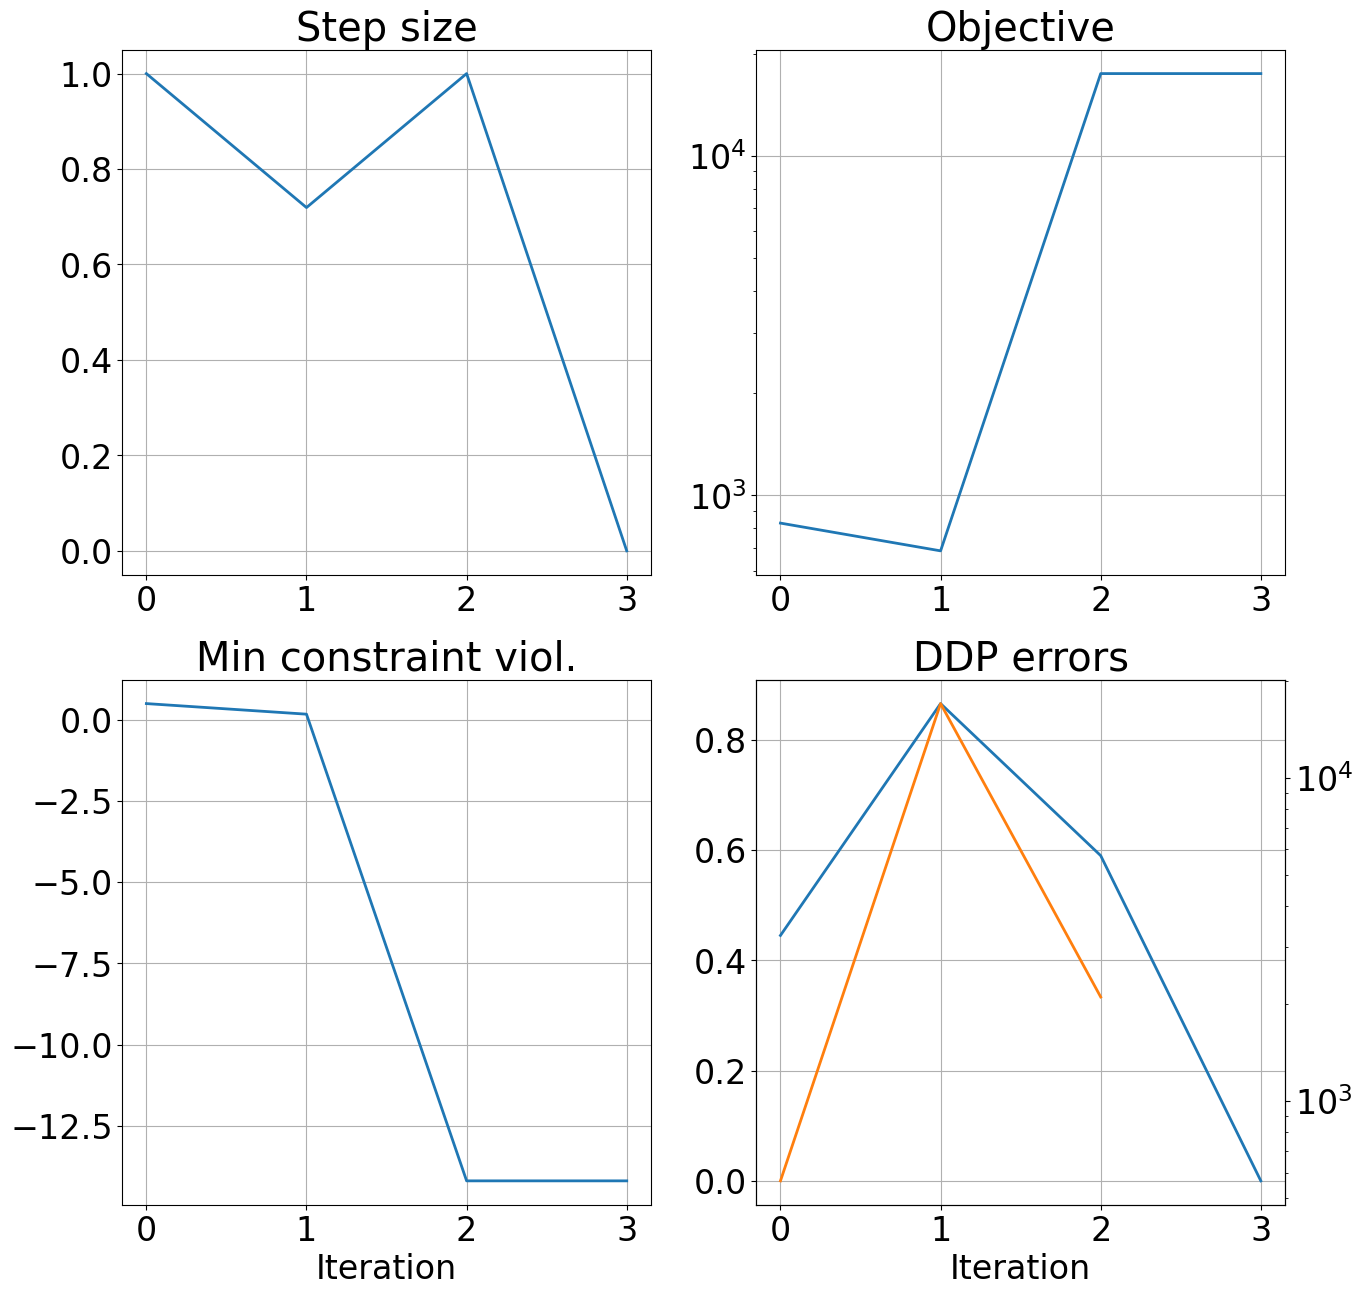

In [ ]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 24})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].plot(history['steplength'], color=colors[0], linewidth=2)
axs[0][0].set_title('Step size')
axs[0][0].grid(True)

axs[0][1].plot(history['obj'], color=colors[0], linewidth=2)
axs[0][1].set_title('Objective')
axs[0][1].set_yscale('log')
axs[0][1].grid(True)

axs[1][0].plot(history['min_viol'], color=colors[0], linewidth=2)
axs[1][0].set_title('Min constraint viol.')
axs[1][0].set_xlabel('Iteration')
axs[1][0].grid(True)

if 'ddp_err' in history:
  axs[1][1].plot(history['ddp_err'], color=colors[0], linewidth=2)
  axs2 = axs[1][1].twinx()
  axs2.plot(history['ddp_err_grad'], color=colors[1], linewidth=2)
  axs2.set_yscale("log")
  axs[1][1].set_title('DDP errors')
  axs[1][1].set_xlabel('Iteration')
  axs[1][1].grid(True)